In [1]:
# Importations
import pandas as pd
import numpy as np

import argparse
import tensorflow

# fonctions
import traintestsplit as tts
from words_txt_to_df import txt_to_df
from nettoyage_fichiers import clean_data, error_image
from harmonisation import harmony_clean

# modèle cnn
import preprocess_cnn as ppcnn
from cnn_model import build_model_cnn

# prédictions
import cnn_pred

# Visualisation
import matplotlib.pyplot as plt

# Evaluation
import evaluation

# Reproductibilité
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

Init Plugin
Init Graph Optimizer
Init Kernel


# Récupération des données et du modèle

In [2]:
print("Lecture de words.txt et transformation en dataframe") 
    #[word_id,ok_err,gray_level,transcript,data_path]
df_words = txt_to_df('words.txt')

print("Suppression des erreurs de lecture d'image du df")
df_words = clean_data(df_words)

print("génération d'un dataframe contenant la répartition du dataset [line_id,set]")
df_tts = tts.text_to_splitDataframe()

print("Split des données")
trainset, testset, validationset = tts.split_data(df_tts, df_words)


# Variables utiles
TARGET_SIZE = (128,32)
BACTH = 100

print("Préparation des données d'entrainement, validation et test")
Xy_train = ppcnn.data_Xy(trainset, TARGET_SIZE, trainset, BACTH)
Xy_valid = ppcnn.data_Xy(validationset, TARGET_SIZE, trainset, BACTH)
Xy_test = ppcnn.data_Xy(testset, TARGET_SIZE, trainset, BACTH)

print("Construction du modèle")
NB_CLASS = len(ppcnn.labels_dict(trainset))
cnn = build_model_cnn(NB_CLASS, TARGET_SIZE)

cnn.load_weights('cnn.weights.h5')


Lecture de words.txt et transformation en dataframe
Suppression des erreurs de lecture d'image du df
Erreur de lecture sur l'image: a01-117-05-02.png
Erreur de lecture sur l'image: r06-022-03-05.png
génération d'un dataframe contenant la répartition du dataset [line_id,set]
Split des données
Préparation des données d'entrainement, validation et test
Metal device set to: Apple M1


2021-12-15 20:47:21.687238: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-15 20:47:21.687340: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Construction du modèle
Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_im (InputLayer)        [(None, 32, 128, 1)]      0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 12, 60, 64)        5248      
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 60, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 12, 60, 64)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 12, 60, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 60, 128)       512       
_________________________________________________________________
activation_1 (Activation)    (None, 12, 

# Prédictions sur les données test

In [3]:
pred_key = cnn_pred.predictions_top5(cnn, testset, target_size = TARGET_SIZE, batch_size = BACTH)
dict_code = ppcnn.labels_dict(trainset)
pred_words = cnn_pred.decoder_pred(pred_key, dict_code)
df_top5  = cnn_pred.df_bilan_top5(testset, pred_words)
df_top5.head()

2021-12-15 20:47:44.165419: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-15 20:47:44.165682: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-12-15 20:47:44.224783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


,data_path,predict_1,predict_2,predict_3,predict_4,predict_5,transcript
0,data/words/m01/m01-049/m01-049-00-00.png,He,he,the,We,let,He
1,data/words/m01/m01-049/m01-049-00-01.png,Miss,1834,With,NOT,1830,rose
2,data/words/m01/m01-049/m01-049-00-02.png,for,fine,the,hope,ten,from
3,data/words/m01/m01-049/m01-049-00-03.png,in,is,his,In,has,his
4,data/words/m01/m01-049/m01-049-00-04.png,fascinating,fur-,It,by,it,breakfast-nook


# Evaluation du modèle

## première prédiction

In [4]:
df_top5['transcript'] = testset.transcript
df_top5['transcript_is_pred1'] = None

for i in range(df_top5.shape[0]):
    df_top5.transcript_is_pred1[i] = evaluation.transcript_in_pred1(df_top5, i)
df_top5.head()

,data_path,predict_1,predict_2,predict_3,predict_4,predict_5,transcript,transcript_is_pred1
0,data/words/m01/m01-049/m01-049-00-00.png,He,he,the,We,let,He,True
1,data/words/m01/m01-049/m01-049-00-01.png,Miss,1834,With,NOT,1830,rose,False
2,data/words/m01/m01-049/m01-049-00-02.png,for,fine,the,hope,ten,from,False
3,data/words/m01/m01-049/m01-049-00-03.png,in,is,his,In,has,his,False
4,data/words/m01/m01-049/m01-049-00-04.png,fascinating,fur-,It,by,it,breakfast-nook,False


In [5]:
df_top5["transcript_is_pred1"].value_counts(normalize = True)

False    0.775148
True     0.224852
Name: transcript_is_pred1, dtype: float64

## 5 meilleures prédictions 

In [6]:
df_top5['transcript_in_top5'] = None

for i in range(df_top5.shape[0]):
    df_top5.transcript_in_top5[i] = evaluation.transcript_in_top5(df_top5, i)
df_top5.head()

,data_path,predict_1,predict_2,predict_3,predict_4,predict_5,transcript,transcript_is_pred1,transcript_in_top5
0,data/words/m01/m01-049/m01-049-00-00.png,He,he,the,We,let,He,True,True
1,data/words/m01/m01-049/m01-049-00-01.png,Miss,1834,With,NOT,1830,rose,False,False
2,data/words/m01/m01-049/m01-049-00-02.png,for,fine,the,hope,ten,from,False,False
3,data/words/m01/m01-049/m01-049-00-03.png,in,is,his,In,has,his,False,True
4,data/words/m01/m01-049/m01-049-00-04.png,fascinating,fur-,It,by,it,breakfast-nook,False,False


In [7]:
df_top5["transcript_in_top5"].value_counts(normalize = True)

True     0.596446
False    0.403554
Name: transcript_in_top5, dtype: float64

**Le modèle CNN a une accuracy qui d'environ 60% dans le top 5 des prédictions alors qu'elle n'est que de 22% pour la première prédiction**

# Visualisation

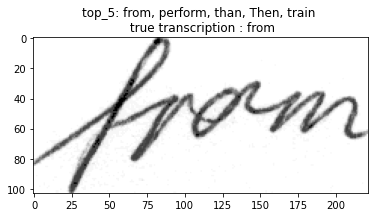

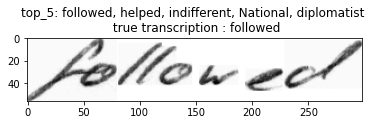

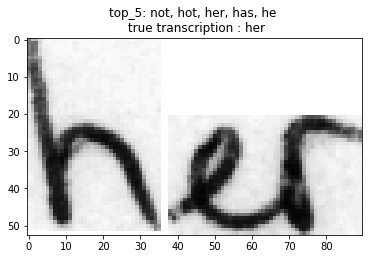

In [8]:
evaluation.viz_pred5(df_top5)